# Test

### Load data

In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def load_data(data_name):
    pkl_file = open(data_name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

Load results

In [2]:
pred = ['bi', 'cnn', '2bi', 'resnet', '1bi', 'lstm', '2bipair', 'cat', 'log', 'xg']
predicted = []

test = load_data('./predictions/test')
test2 = load_data('./predictions/test_m')

for i in range(len(pred)):
    predicted.append(load_data('./predictions/pred_' + pred[i]))

Reshape results 

In [3]:
shape = (780 * 73, 2)

test = np.array(test).reshape(shape)

for i in range(len(pred[:7])):
    predicted[i] = np.array(predicted[i]).reshape(shape)

### Metrics 

Cutoffs (L∕10, L∕5, L∕2 and L)

In [193]:
# F1_score, precision, recall

import operator
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def score(test_label, predicted, metric, model):
    
    id_score = {}
    pred = []
    test = []
    
    L = 0
    L_2 = 0
    L_5 = 0
    L_10 = 0
    
    for i in range(len(predicted)):
        id_score[i] = predicted[i][1]
        
    for key, value in reversed(sorted(id_score.items(), key=operator.itemgetter(1))):
        
        pred.append(np.argmax([1 - value, value]))
        
        if model == 'neural':
            test.append(np.argmax(test_label[key]))
            
        elif model == 'machine':
            test.append(test_label[key])
            
        else:
            raise ValueError('No model type was found')
            
        
    if metric == 'recall':
        
        L = recall_score(test, pred)
        L_2 = recall_score(test[:len(test) // 2], pred[:len(pred) // 2])
        L_5 = recall_score(test[:len(test) // 5], pred[:len(pred) // 5]) 
        L_10 = recall_score(test[:len(test) // 10], pred[:len(pred) // 10])
        
    elif metric == 'f1':
        
        L = f1_score(test, pred)
        L_2 = f1_score(test[:len(test) // 2], pred[:len(pred) // 2])
        L_5 = f1_score(test[:len(test) // 5], pred[:len(pred) // 5])
        L_10 = f1_score(test[:len(test) // 10], pred[:len(pred) // 10])
        
    elif metric == 'precision':
        
        L = precision_score(test, pred)
        L_2 = precision_score(test[:len(test) // 2], pred[:len(pred) // 2])
        L_5 = precision_score(test[:len(test) // 5], pred[:len(pred) // 5])
        L_10 = precision_score(test[:len(test) // 10], pred[:len(pred) // 10])
        
    else:
        
        raise ValueError('No metric was found')
            
    return L, L_2, L_5, L_10

    
def results(test_label, proba, model):
    
    result = []
    metrics = ['f1', 'precision', 'recall']
    print_metrics = ['F1 score:', 'Precision score:', 'Recall score:']
    
    for i in range(len(metrics)):
        
        L, L_2, L_5, L_10 = score(test_label, proba, metrics[i], model)
        result.append([L, L_2, L_5, L_10])
    
    return result


def highlight_max(s):

    is_max = s == s.max()
    
    return ['background-color: yellow' if v else '' for v in is_max]

Get score for each model

In [194]:
res = []

for i in range(len(pred[:7])):
    res.append(results(test, predicted[i], 'neural'))
    
for i in range(7, len(pred)):
    res.append(results(test2, predicted[i], 'machine'))

In [195]:
models = ['Bidirectional LSTM', 'CNN', 'ResNet + BiLSTM', 'ResNet', 
          'Conv1D + BiLSTM', 'LSTM', 'ResNet + BiLSTM (pairwise)', 'CatBoost', 'Logistic Regression', 'XGBoost']

L_array = ['L', 'L/2', 'L/5', 'L/10']

In [196]:
def get_df(x, models, L_array, metric):
    
    """
    x - scores
    metric - 0 : f1
             1 : precision
             2 : recall
    """
    
    df = []

    for i in range(np.shape(x)[0]):
        df.append(x[i][metric])

    df = pd.DataFrame(df)
    df.index = models
    df.columns = L_array
    
    return df

In [197]:
# F1 score

df_f1 = get_df(res, models, L_array, 0)
df_f1.style.apply(highlight_max)

,L,L/2,L/5,L/10
Bidirectional LSTM,0.771729,0.779323,0.855105,0.980392
CNN,0.744203,0.758577,0.863153,0.972388
ResNet + BiLSTM,0.774625,0.785463,0.864245,0.980666
ResNet,0.761729,0.773674,0.850789,0.973407
Conv1D + BiLSTM,0.764706,0.772076,0.852714,0.979844
LSTM,0.740643,0.754162,0.865148,0.973314
ResNet + BiLSTM (pairwise),0.791192,0.801294,0.865514,0.975899
CatBoost,0.779804,0.786592,0.86586,0.989799
Logistic Regression,0.637077,0.662748,0.741596,0.874704
XGBoost,0.785196,0.791615,0.869489,0.98953


In [198]:
# Precision

df_p = get_df(res, models, L_array, 1)
df_p.style.apply(highlight_max)

,L,L/2,L/5,L/10
Bidirectional LSTM,0.879008,0.879008,0.879008,0.961538
CNN,0.88879,0.88879,0.88879,0.946259
ResNet + BiLSTM,0.874562,0.874562,0.874562,0.962065
ResNet,0.857814,0.857814,0.857814,0.948191
Conv1D + BiLSTM,0.862004,0.862004,0.862004,0.960485
LSTM,0.900399,0.900399,0.900399,0.948015
ResNet + BiLSTM (pairwise),0.863538,0.863538,0.863538,0.952933
CatBoost,0.908456,0.908456,0.908456,0.979803
Logistic Regression,0.768555,0.768555,0.768555,0.777309
XGBoost,0.910235,0.910235,0.910235,0.979276


In [199]:
# Recall

df_p = get_df(res, models, L_array, 2)
df_p.style.apply(highlight_max)

,L,L/2,L/5,L/10
Bidirectional LSTM,0.687788,0.699945,0.832468,1
CNN,0.640077,0.661642,0.838954,1
ResNet + BiLSTM,0.695186,0.712841,0.854169,1
ResNet,0.685001,0.704566,0.843878,1
Conv1D + BiLSTM,0.687145,0.699138,0.843622,1
LSTM,0.629034,0.648789,0.832553,1
ResNet + BiLSTM (pairwise),0.730031,0.74742,0.867499,1
CatBoost,0.683071,0.693555,0.82708,1
Logistic Regression,0.544012,0.582549,0.716464,1
XGBoost,0.690361,0.700348,0.832235,1


### Triangle to matrix

In [5]:
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, file, figsize=(10,10)):

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
                
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, cmap='YlGnBu', fmt='', ax=ax)
    plt.savefig(file, dpi=200)

In [6]:
test = test.reshape(780, 73, 2)

for i in range(len(pred)):
    predicted[i] = np.array(predicted[i]).reshape(780, 73, 2)

In [7]:
test_matrix = [[[0] * 40 for i in range(40)] for i in range(np.shape(test)[1])]
pred_matrix = [[[0] * 40 for i in range(40)] for i in range(np.shape(test)[1])]
predictions = [[] for i in range(np.shape(test)[1])]
test_val = [[] for i in range(np.shape(test)[1])]

for i in range(np.shape(test)[1]):
    cnt = 0
    for j in range(40):
        for k in range(j + 1, 40):
            test_matrix[i][j][k] = np.argmax(test[cnt][i])
            test_matrix[i][k][j] = np.argmax(test[cnt][i])
            test_val[i].append(np.argmax(test[cnt][i]))
            
            pred_matrix[i][j][k] = np.argmax(predicted[6][cnt][i])
            pred_matrix[i][k][j] = np.argmax(predicted[6][cnt][i])
            predictions[i].append(np.argmax(predicted[6][cnt][i]))
            
            cnt += 1

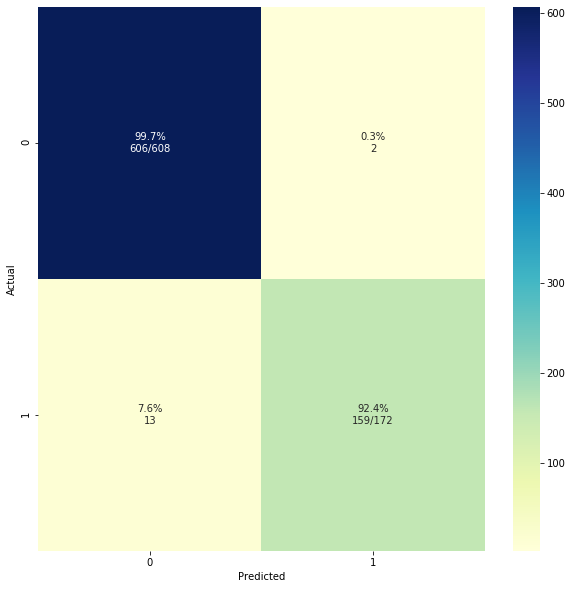

In [382]:
cm_analysis(test_val[34], predictions[34], labels = [0, 1], file='confusion_matrix')

In [317]:
test_matrix = np.array(test_matrix)
pred_matrix = np.array(pred_matrix)

In [314]:
test_matrix.shape, pred_matrix.shape

((73, 40, 40), (73, 40, 40))

### Visualization

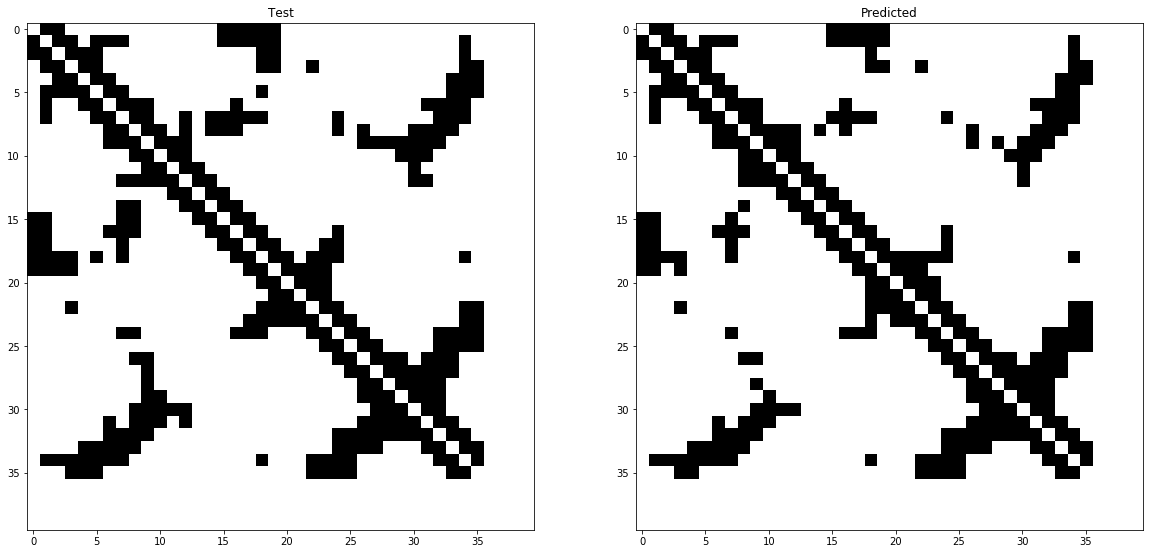

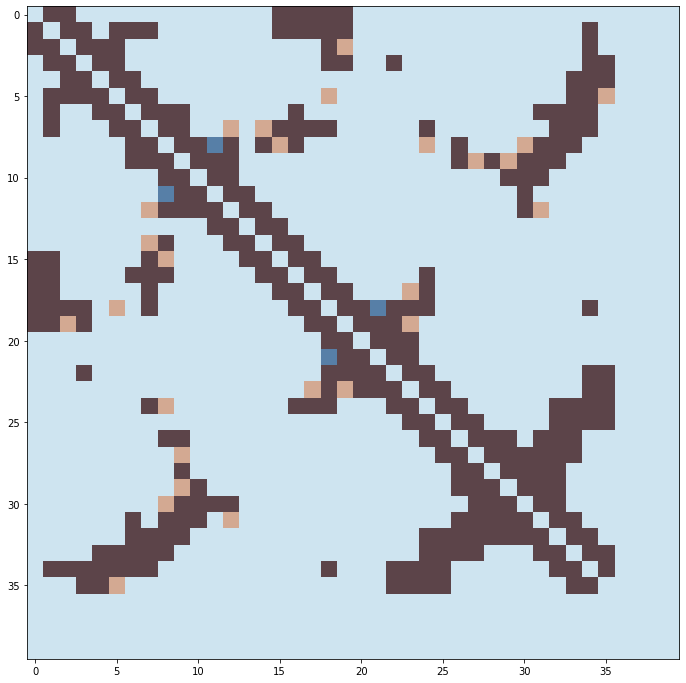

In [52]:
import cmasher as cmr

cmap = cmr.eclipse
prot_number = 34

visual_pred = pred_matrix[prot_number]
visual_test = test_matrix[prot_number]

fig, (ax1, ax2)=plt.subplots(nrows = 1, ncols = 2, figsize = (20, 20))

ax1.set_title('Test')
ax1.imshow(visual_test, cmap='Greys')

# for i in range(40):
#         for j in range(40):
#             text = ax1.text(j, i, visual_test[i][j],
#                            ha="center", va="center", color="black")
            
ax2.set_title('Predicted')
ax2.imshow(visual_pred, cmap='Greys')

# for i in range(40):
#         for j in range(40):
#             text = ax2.text(j, i, visual_pred[i][j],
#                            ha="center", va="center", color="black")

plt.show()


def visualize(prot_number):
    visual_pred = pred_matrix[prot_number]
    visual_test = test_matrix[prot_number]
    fig=plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 1, 1)
    plt.imshow(visual_test, cmap='Paired')
    plt.imshow(visual_pred, alpha=.5, cmap='Blues')
    plt.show()

visualize(prot_number)

In [ ]:
# 9, 20, 21, 34, 42, 62